In [1]:
import itertools
import copy
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import zconfint
from matplotlib import pyplot as plt

In [2]:
liv = np.array([49, 58, 75, 110, 112, 132, 151, 276, 281, 362])

In [3]:
stats.wilcoxon(liv - 200)

WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

In [4]:
tree1 = np.array([22, 22, 15, 13, 19, 19, 18, 20, 21, 13, 13, 15])
tree2 = np.array([17, 18, 18, 15, 12, 4, 14, 15, 10])

In [5]:
stats.mannwhitneyu(tree1, tree2)

MannwhitneyuResult(statistic=27.0, pvalue=0.02900499272087373)

In [6]:
import pandas as pd

In [7]:
data = pd.read_csv("challenger.txt",sep = "\t", header = 0)

In [8]:
data

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0
5,Jun18.83,22.2,0
6,Aug30.83,22.8,0
7,Nov28.83,21.1,0
8,Feb03.84,13.9,1
9,Apr06.84,17.2,1


In [9]:
data_in = data[data["Incident"] == 1]["Temperature"].values
data_norm = data[data["Incident"] == 0]["Temperature"].values

In [10]:
data_in

array([21.1, 13.9, 17.2, 21.1, 11.7, 23.9, 14.4])

In [11]:
data_norm

array([18.9, 20.6, 20. , 19.4, 22.2, 22.8, 21.1, 25.6, 19.4, 19.4, 23.9,
       21.1, 27.2, 24.4, 26.1, 24.4])

In [27]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


np.random.seed(0)

data_boo_norm = get_bootstrap_samples(data_norm, 1000).mean(axis = 1)

data_boo_inc = get_bootstrap_samples(data_in, 1000).mean(axis = 1)

print((stat_intervals(data_boo_inc-data_boo_norm, 0.05)))

[-7.93861607 -1.42299107]


In [61]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)


def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        index1 = index.copy()
        np.random.shuffle(index1)
        indices.add(tuple(index1))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), [i for i in list(range(n)) if i not in index]) \
                    for index in itertools.combinations(list(range(n)), n1)]

    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr


def permutation_test(sample,
                     mean,
                     max_permutations=None,
                     alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    t_stat = permutation_t_stat_ind(sample, mean)

    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)

    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0.
                    for x in zero_distr]) / len(zero_distr)

    if alternative == 'less':
        return sum([1. if x <= t_stat else 0.
                    for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0.
                    for x in zero_distr]) / len(zero_distr)


np.random.seed(0)

permutation_test(data_boo_norm,data_boo_inc, max_permutations=10000, alternative='greater')

0.0001

In [56]:
a = np.append(data_boo_inc, data_boo_norm)
np.random.shuffle(a)

In [57]:
a[:data_boo_inc.shape[0]].mean() - a[data_boo_inc.shape[0]:].mean()

0.05908482142857352

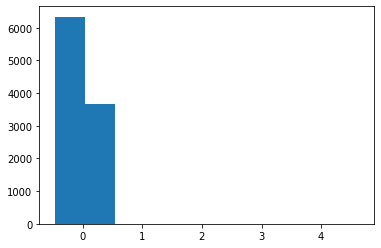

In [58]:
plt.hist(permutation_zero_dist_ind(data_boo_norm, data_boo_inc, max_combinations = 10000))
plt.show()

(array([  7.,   5.,  52., 133., 205., 228., 219., 100.,  41.,  10.]),
 array([-1.1625    , -0.09053571,  0.98142857,  2.05339286,  3.12535714,
         4.19732143,  5.26928571,  6.34125   ,  7.41321429,  8.48517857,
         9.55714286]),
 <a list of 10 Patch objects>)

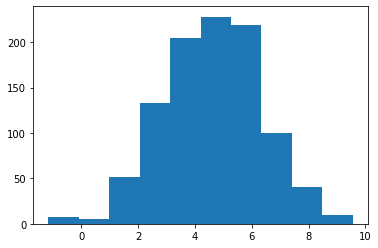

In [59]:
plt.hist(data_boo_norm - data_boo_inc)

In [16]:
data_boo_norm.mean() - data_boo_inc.mean()

4.632743749999996

In [26]:
 list(range(5))

[0, 1, 2, 3, 4]